<a href="https://colab.research.google.com/github/gregorio-saporito/hate-speech-detection/blob/main/main3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Mining and Sentiment Analysis: Hate Speech Detection
Gregorio Luigi Saporito - DSE (2020-2021)

In [1]:
!pip install text-preprocessing
!pip install tweet-preprocessor
!pip install -U nltk[twitter]

     |████████████████████████████████| 2.7MB 5.3MB/s 
     |████████████████████████████████| 62.6MB 62kB/s 
     |████████████████████████████████| 286kB 27.6MB/s 
     |████████████████████████████████| 327kB 37.0MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85395 sha256=dbc643cce6c74a052e919594c96b15cfc33d6864af0a1f4ab67dfb405cb77a80
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick
     |████████████████████████████████| 1.5MB 4.9MB/s 
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [13]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import preprocessor as p
from text_preprocessing import preprocess_text
from text_preprocessing import to_lower, expand_contraction, remove_number, remove_punctuation, remove_whitespace, normalize_unicode, lemmatize_word
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import multiprocessing
from tqdm import tqdm
from sklearn import utils
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import statistics as st
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from mlxtend.feature_selection import ColumnSelector

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
nltk.download('vader_lexicon') 

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

### Upload the data to session storage
Upload here below the __labeled_data.csv__ file. The labels correspond to
- 0: hate speech
- 1: offensive language
- 2: neither

In [4]:
# upload here the data
uploaded = files.upload()

Saving labeled_data.csv to labeled_data.csv


In [5]:
# read the csv file, select the columns of interest, and rename them
fields = ['Unnamed: 0', 'class', 'tweet']
raw = pd.read_csv('labeled_data.csv', usecols=fields)\
  .rename(columns={"Unnamed: 0": "id", "class": "label"})

### Inspect the data

In [6]:
# snapshot of the first rows
raw.head()

,id,label,tweet
0,0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [7]:
# size of the dataset
raw.shape

(24783, 3)

In [8]:
# inspect the presence of missing values
print(
    'Check for null values\n' +
    str(raw.isnull().sum()) + '\n'
    'Check for na values\n' +
    str(raw.isna().sum())
)

Check for null values
id       0
label    0
tweet    0
dtype: int64
Check for na values
id       0
label    0
tweet    0
dtype: int64


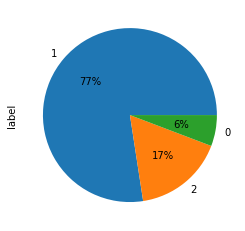

In [9]:
# inspect the classes' frequency
raw['label'].value_counts(normalize=True).plot.pie(autopct='%1.0f%%')
plt.show()

### Preprocessing and Feature Extraction

In [10]:
# normalise tags, URLS, emoji, and smiley
# the hashtags are left out because they could incorporate hate speech to detect
p.set_options(p.OPT.MENTION, p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
raw['normalised'] = [p.tokenize(x) for x in raw['tweet']]

# Preprocess text using custom preprocess functions in the pipeline
def preprocess_txt(x):
  preprocess_functions = [to_lower, expand_contraction, remove_number, remove_punctuation,
                          remove_whitespace, normalize_unicode, lemmatize_word]
  preprocessed_text = preprocess_text(x, preprocess_functions)
  return preprocessed_text.replace("rt ", "").strip()

raw['cleaned'] = [preprocess_txt(x) for x in raw['normalised']]

### Train Test Split

In [33]:
X = raw
y = raw['label'].to_numpy().ravel()

# split the sample in train and test
X_train, X_test, y_train, y_test = train_test_split(raw[['cleaned']], raw['label'], test_size=0.1, random_state=123)

In [41]:
X = raw
y = raw['label'].to_numpy().ravel()

pipe = Pipeline([
    ('col_selector', ColumnSelector(cols=('cleaned'),drop_axis=True)),
    ('tfidf', TfidfVectorizer()),
    ('logistic', LogisticRegression(max_iter=1000, class_weight='balanced')),
])

cross_val_score(pipe, X, y, cv=5)

array([0.81500908, 0.82509582, 0.86060117, 0.85956416, 0.85451977])

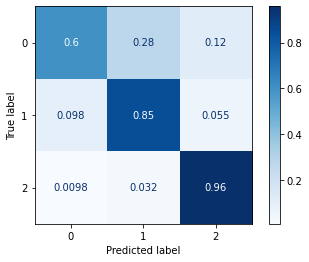

In [42]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
model = pipe.fit(X_train,y_train)
plot_confusion_matrix(model, X_test, y_test, normalize='true',cmap=plt.cm.Blues)